In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40869,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:43363,Total threads: 4
Dashboard: /proxy/40463/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:40827,


In [3]:
def isosurface(field, target, dim):
    """
    Linearly interpolate a coordinate isosurface where a field
    equals a target

    Parameters
    ----------
    field : xarray DataArray
        The field in which to interpolate the target isosurface
    target : float
        The target isosurface value
    dim : str
        The field dimension to interpolate
        
    Examples
    --------
    Calculate the depth of an isotherm with a value of 5.5:
    
    >>> temp = xr.DataArray(
    ...     range(10,0,-1),
    ...     coords={"depth": range(10)}
    ... )
    >>> isosurface(temp, 5.5, dim="depth")
    <xarray.DataArray ()>
    array(4.5)
    """
    slice0 = {dim: slice(None, -1)}
    slice1 = {dim: slice(1, None)}

    field0 = field.isel(slice0).drop(dim)
    field1 = field.isel(slice1).drop(dim)

    crossing_mask_decr = (field0 > target) & (field1 <= target)
    crossing_mask_incr = (field0 < target) & (field1 >= target)
    crossing_mask = xr.where(
        crossing_mask_decr | crossing_mask_incr, 1, np.nan
    )

    coords0 = crossing_mask * field[dim].isel(slice0).drop(dim)
    coords1 = crossing_mask * field[dim].isel(slice1).drop(dim)
    field0 = crossing_mask * field0
    field1 = crossing_mask * field1

    iso = (
        coords0 + (target - field0) * 
        (coords1 - coords0) / (field1 - field0)
    )

    return iso.max(dim, skipna=True)

In [4]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['z20'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [5]:
def regrid_deep(ds):
    #drop unnecessary coords from input
    ds = ds.drop(["geolon_c", "geolat_c", 'xu_ocean', 'nv', 'yu_ocean', 'sw_ocean','st_edges_ocean','sw_edges_ocean', 'grid_xu_ocean', 'grid_yt_ocean', 'potrho', 'potrho_edges', 'grid_xt_ocean', 'grid_yu_ocean'])
    #create output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop and rename part of input
    ds_in = ds.drop({'xt_ocean', 'yt_ocean'}).rename({"geolon_t": "longitude", "geolat_t": "latitude", "st_ocean":"depth"})
    #creatre regridder
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear', periodic=True)
    regridded = regridder(ds_in['temp'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

def get_regrid_z20_ncfile(file_dir):#, outfile):
    z20s=[]
    for file in glob.glob(file_dir+"ocean_month.nc-*"):
        ds = xr.open_dataset(file, chunks = {"time":12})
        #regrid
        ds_re = regrid_deep(ds)
        #get 20 eg isotherm
        ds_z20 = isosurface(ds_re, 293.15, dim = "depth")
        z20s.append(ds_z20)
    z20 = xr.concat(z20s, dim = 'time')
    #convert to netcdf
    #z20.to_netcdf("/g/data/e14/sm2435/Pacemaker/"+outfile)
    return z20

In [6]:
#now do for the control and other variables

In [6]:
DS = xr.open_mfdataset("/scratch/e14/sm2435/archive/cy286/history/ocn/ocean_month.nc-*", parallel = True, use_cftime=True, chunks= {"time":240})
z20 = isosurface(DS.temp, 293.15, dim = "st_ocean")
#try to save files
ds1 = z20.to_dataset(name = "z20")
ds1.to_netcdf("/g/data/e14/sm2435/Exps_ACCESS_initial/Var_pace_z20.nc")

2023-09-01 12:59:48,767 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 15.04 GiB -- Worker memory limit: 17.89 GiB
2023-09-01 13:00:07,784 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:41973 (pid=1242395) exceeded 95% memory budget. Restarting...
2023-09-01 13:00:08,825 - distributed.nanny - WARNING - Restarting worker
2023-09-01 13:00:10,217 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:43363 -> tcp://127.0.0.1:41973
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/

In [8]:
DS = xr.open_mfdataset("/scratch/e14/sm2435/archive/cw323/history/ocn/ocean_month.nc-*", parallel = True, use_cftime=True, chunks= {"time":240})
z20 = isosurface(DS.temp, 293.15, dim = "st_ocean")
#try to save files
ds1 = z20.to_dataset(name = "z20")
ds1.to_netcdf("/g/data/e14/sm2435/Exps_ACCESS_initial/obs_pace_z20.nc")

2023-09-01 13:11:16,890 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 14.71 GiB -- Worker memory limit: 17.89 GiB
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
2023-09-01 13:11:20,580 - distributed.worker.memory - WARNING - Worker is at 30% memory usage. Resuming worker. Process memory: 5.53 GiB -- Worker memory limit: 17.89 GiB
2023-09-01 13:11:23,310 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 15.02 GiB -- Worker memory limit: 17.89 GiB
2023-09-01 13:11:26,775 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 14.79 GiB -- Worker memory limit: 17.89 GiB
2023-09-01 13:11:27,590 - distributed.worker.memory - WARNING - Worker is at 35% memory usage. Resu

In [22]:
DS = xr.open_mfdataset("/g/data/hh5/tmp/zg0866/ACCESS-CM2_archive/cm000/history/ocn/ocean_month.nc-*", parallel=True)
z20 = isosurface(DS.temp, 293.15, dim = "st_ocean")
#try to save files
ds1 = z20.to_dataset(name = "z20")
ds1.to_netcdf("/g/data/e14/sm2435/Pacemaker/ctrl_z20.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [23]:
DS = xr.open_mfdataset("/scratch/w97/zg0866/cs947_raw/history/ocn/ocean_month.nc-*", parallel=True)
z20 = isosurface(DS.temp, 293.15, dim = "st_ocean")
#try to save files
ds1 = z20.to_dataset(name = "z20")
ds1.to_netcdf("/g/data/e14/sm2435/Pacemaker/mod_pace_z20.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [ ]:
#now load wind stress

In [9]:
def open_u_winds(file_dir):
    DS = xr.open_mfdataset(glob.glob(file_dir+"ocean_month.nc-*"), parallel=True)
    tauu = DS.tau_x
    #try to save files
    ds1 = tauu.to_dataset(name = "tauu")
    return ds1

In [10]:
def open_v_winds(file_dir):
    DS = xr.open_mfdataset(glob.glob(file_dir+"ocean_month.nc-*"), parallel=True)
    tauv = DS.tau_y
    #try to save files
    ds1 = tauv.to_dataset(name = "tauv")
    return ds1

In [11]:
def open_winds(file_dir):
    DS = xr.open_mfdataset(glob.glob(file_dir+"ocean_month.nc-*"), parallel=True)
    tauu = DS.tau_x
    tauv = DS.tau_y                    
    #try to save files
    ds1 = tauu.to_dataset(name = "tauu")
    ds2 = tauu.to_dataset(name = "tauv")
    return ds1, ds2

In [9]:
u = open_u_winds("/scratch/w97/zg0866/cs947_raw/history/ocn/")
u.to_netcdf("/g/data/e14/sm2435/Pacemaker/mod_uwnd.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array

KeyboardInterrupt: 

In [10]:
v = open_v_winds("/scratch/w97/zg0866/cs947_raw/history/ocn/")
v.to_netcdf("/g/data/e14/sm2435/Pacemaker/mod_vwnd.nc")

Process Dask Worker process (from Nanny):
2023-08-11 13:18:47,229 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/process.py", line 190, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/nanny.py", line 986, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/en

KeyboardInterrupt: 

In [12]:
u = open_u_winds("/scratch/e14/sm2435/archive/cy286/history/ocn/")
u.to_netcdf("/g/data/e14/sm2435/Exps_ACCESS_initial/var_uwnd.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [13]:
v = open_v_winds("/scratch/e14/sm2435/archive/cy286/history/ocn/")
v.to_netcdf("/g/data/e14/sm2435/Exps_ACCESS_initial/var_vwnd.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [14]:
u = open_u_winds("/scratch/e14/sm2435/archive/cw323/history/ocn/")
u.to_netcdf("/g/data/e14/sm2435/Exps_ACCESS_initial/ob_uwnd.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [15]:
v = open_v_winds("/scratch/e14/sm2435/archive/cw323/history/ocn/")
v.to_netcdf("/g/data/e14/sm2435/Exps_ACCESS_initial/ob_vwnd.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [ ]:
u = open_u_winds("/g/data/hh5/tmp/zg0866/ACCESS-CM2_archive/cm000/history/ocn/")
u.to_netcdf("/g/data/e14/sm2435/Pacemaker/ctrl_uwnd.nc")

In [ ]:
v = open_v_winds("/g/data/hh5/tmp/zg0866/ACCESS-CM2_archive/cm000/history/ocn/")
v.to_netcdf("/g/data/e14/sm2435/Pacemaker/ctrl_vwnd.nc")

In [14]:
OC_z20 = get_regrid_z20_ncfile("/scratch/e14/sm2435/archive/cw323/history/ocn/")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cf_xarray/accessor.py:1663: UserWarning: Variables {'geolon_t', 'geolat_t'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xar

In [15]:
VC_z20 = get_regrid_z20_ncfile("/scratch/e14/sm2435/archive/cy286/history/ocn/")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cf_xarray/accessor.py:1663: UserWarning: Variables {'geolon_t', 'geolat_t'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xar

In [ ]:
VC_z20.mean('time').plot()

In [ ]:
ctrl_z20 = get_regrid_z20_ncfile("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/")

In [ ]:
MC_z20 = get_regrid_z20_ncfile("/scratch/w97/zg0866/cs947_raw/history/ocn/")

In [ ]:
temp..where(~np.isfinite(age_mean.shift({'st_ocean': -1})))

In [83]:
test = isosurface(temp, 293.15, dim = "st_ocean")

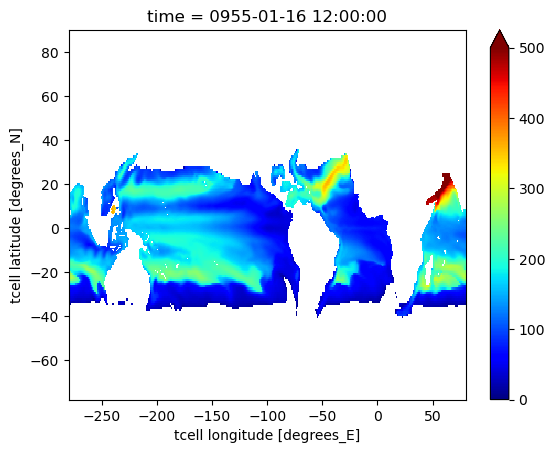

In [85]:
test[0].plot(vmin=0, vmax = 500, cmap = 'jet')

In [87]:
slice0 = {"st_ocean": slice(None, -1)}
field0 = temp.isel(slice0).drop("st_ocean")

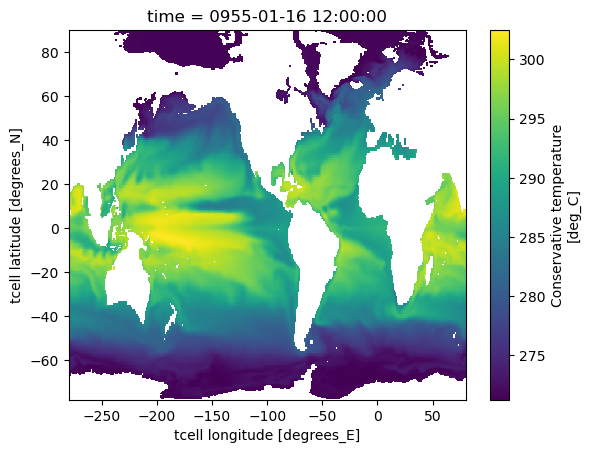

In [100]:
field0[0,10].plot()

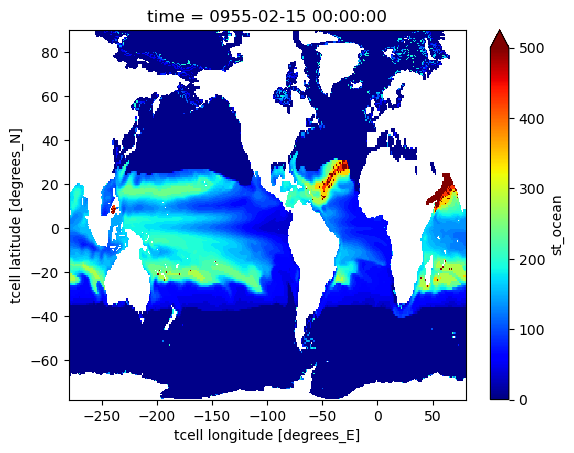

In [75]:
biggest_temp_id[1].plot(vmin=0, vmax = 500, cmap = 'jet')

In [35]:
temp.st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([5.000000e+00, 1.500000e+01, 2.500000e+01, 3.500000e+01, 4.500000e+01,
       5.500000e+01, 6.500000e+01, 7.500000e+01, 8.500000e+01, 9.500000e+01,
       1.050000e+02, 1.150000e+02, 1.250000e+02, 1.350000e+02, 1.450000e+02,
       1.550000e+02, 1.650000e+02, 1.750000e+02, 1.850000e+02, 1.950000e+02,
       2.050000e+02, 2.168468e+02, 2.413490e+02, 2.807807e+02, 3.432505e+02,
       4.273156e+02, 5.367156e+02, 6.654141e+02, 8.127816e+02, 9.690651e+02,
       1.130935e+03, 1.289605e+03, 1.455770e+03, 1.622926e+03, 1.801558e+03,
       1.984855e+03, 2.182905e+03, 2.388417e+03, 2.610935e+03, 2.842564e+03,
       3.092205e+03, 3.351295e+03, 3.628058e+03, 3.913264e+03, 4.214495e+03,
       4.521918e+03, 4.842566e+03, 5.166130e+03, 5.499245e+03, 5.831294e+03])
Coordinates:
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean

In [101]:
file_dir = "test"

In [102]:
file_dir+"ocean_month.nc-*"

'testocean_month.nc-*'